# Introduction

I am a happy user of the RunKeeper app (on iOS). I use it to track all of my runs, my bike rides, and the occassional hike. I appreciate that it comes with a variety of training plans, and I used one of those plans to prepare for my first 10-miler back in April 2016, and I'm following a plan now in preparation for a half marathon later this fall.

While I am satisfied overall, I have suspected for a while that the 'charts' feature on some activities was inaccurate. I decided to drill into this a bit deeper and see if I could figure out why the charts might be off.

On July 6th, I did a 50-minute training run that consisted of a five-minute warm-up period followed by nine intervals of 3 minutes as fast as I could go followed by two minutes of recovery (slow jog or walk). The RunKeeper app tracked my position using the iPhone's built-in GPS capability. Here's what RunKeeper reported as my time for each interval.

| Plan | Interval (mm:ss) | Elapsed Time (mm:ss) | Pace (min/mile) |
| ---- | ----- | ----:| -----:|
| warmup | 5:00 | 5:00  | 9:25  |
| fast | 3:00 | 8:00  | 7:24  |
| slow | 2:00 | 10:00 | 9:44  |
| fast | 3:00 | 13:00 | 7:30  |
| slow | 2:00 | 15:00 | 10:16 |
| fast | 3:00 | 18:00 | 7:32  |
| slow | 2:00 | 20:00 | 12:16 |
| fast | 3:00 | 23:00 | 7:43  | 
| slow | 2:00 | 25:00 | 12:51 |
| fast | 3:00 | 28:00 | 7:58  |
| slow | 2:00 | 30:00 | 14:02 |
| fast | 3:00 | 32:00 | 8:12  |
| slow | 2:00 | 35:00 | 15:44 |
| fast | 3:00 | 38:00 | 8:00  |
| slow | 2:00 | 40:00 | 14:37 |
| fast | 3:00 | 43:00 | 8:09  |
| slow | 2:00 | 45:00 | 13:39 |
| fast | 3:00 | 48:00 | 8:25  |
| slow | 2:00 | 50:00 | 9:46  |
| extra| 0:05 | 50:05 | 9:08  |

When I view the Pace chart on the RunKeeper iOS app, it shows me the following:

![Pace chart from RunKeeper iOS app](RunKeeper-iOS-PaceChart.png)

While the lowest line on the chart isn't labeled, based on the vertical scale you can estimate that it should be 7:47. Here's where the trouble arises. If you look back at the interval times above, you'll see that in my first fast interval I averaged a 7:24 min/mile pace, and 7:30 min/mile in my second, and 7:32 min/mile in my third. Again, those are _average_ paces for the duration of the interval. I trust the average pace estimates relatively well, because those should just be calculated by taking the time interval and dividing it by the distance traveled during that time interval. 

The chart, however, shows that my instantaneous pace never got below 7:47. Unfortunately, that can't be true. For my _average_ pace to have been 7:24 min/mile during the first fast interval, I either had to be running at exactly 7:24 min/mile during the entire three-minute period, or I had to run _faster_ than that pace at some point during that period to compensate for traveling slower than the average during other times during that interval.

Based on the interval averages (which I believe to be relatively accurate), I can't place much trust in this chart. What I suspect is happening here is that the data has been smoothed quite a bit, perhaps using a sliding average window or a low-pass filter. I can imagine that the speed or pace data would be fairly noisy, so it makes sense that some smoothing might be required, but I feel like perhaps they've erred too heavily on the side of presenting a clean graph at the cost of losing the real features in the data.

The rest of this iPython notebook is my attempt to get a better understanding of what the RunKeeper app is doing and if there might be a better way to present the information.

# Getting the Data

Via the RunKeeper web interface, it's pretty straightforward to export the track from a run (or any _activity_ as they call them). They give you the option of exporting the track in a GPX (GPS Exchange Format) or a KML (Google Earth) format. Despite not being familiar with the GPX format, I opted to start there, as I didn't want to mess with a separate application.

Here's the GPX export of the run in question if you'd like to have a look.

In [2]:
from IPython.display import FileLink
FileLink('RK_gpx_2016-07-06_0724.gpx')

/home/jovyan/work/RK_gpx_2016-07-06_0724.gpx

Again, not having looked at this format before, I wasn't sure exactly what would be in there. Looking at it in a text editor (vi), you can see it's actually a pretty straightforward XML representation of points:

    <?xml version="1.0" encoding="UTF-8"?>
    <gpx
      version="1.1"
      creator="Runkeeper - http://www.runkeeper.com"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xmlns="http://www.topografix.com/GPX/1/1"
      xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd"
      xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1">
    <trk>
      <name><![CDATA[Running 7/6/16 7:24 am]]></name>
      <time>2016-07-06T11:24:03Z</time>
    <trkseg>
    <trkpt lat="38.808472000" lon="-77.058002000"><ele>8.2</ele><time>2016-07-06T11:24:03Z</time></trkpt>
    <trkpt lat="38.808502000" lon="-77.057983000"><ele>8.3</ele><time>2016-07-06T11:24:04Z</time></trkpt>
    <trkpt lat="38.808591000" lon="-77.057919000"><ele>8.4</ele><time>2016-07-06T11:24:10Z</time></trkpt>
    <trkpt lat="38.808671000" lon="-77.057833000"><ele>8.4</ele><time>2016-07-06T11:24:16Z</time></trkpt>
    <trkpt lat="38.808753000" lon="-77.057760000"><ele>8.5</ele><time>2016-07-06T11:24:23Z</time></trkpt>
       ... another 700 or so lines
    </trkseg>
    </trk>
    </gpx>
    
You can see that each of the points in a track segment provide a latitude, longitude, elevation, and timestamp. The first thing I noticed, though is that the time interval between successive track points is not uniform.

This format seems easy enough to parse just using standard XML libraries available for Python, but a quick search confirmed that there's already a Python library dedicated just to the GPX format, so I went ahead and grabbed it.

In [4]:
!pip2 install gpxpy

  Running setup.py bdist_wheel for gpxpy ... - done
  Stored in directory: /home/jovyan/.cache/pip/wheels/6b/61/2b/52d076aacd4c16fec7d4f810aa2717e60d0accfee128e3f92c
Successfully built gpxpy


In [113]:
import gpxpy.parser as parser

with open( 'RK_gpx_2016-07-06_0724.gpx', 'r' ) as gpx_file :
    gpx_parser = parser.GPXParser( gpx_file )
    gpx_parser.parse()

gpx = gpx_parser.gpx

times, lng_points, lat_points, ele_points = [], [], [], []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            times.append( point.time )
            lat_points.append( point.latitude )
            lng_points.append( point.longitude )
            ele_points.append( point.elevation )

The times array contains the timestamp of each GPS data point recorded in UTC (aka Greenwich Mean Time). It'd probably be more valuable to us to look at them in relative time from the start of the track instead. I'll make this shift by just subtracting off the first time value from every element of the array. It's still easiest for me to let matplotlib handle the axis range, so I convert back to a `datetime` object.

In [118]:
from datetime import datetime
times = [datetime.strptime(str(t - times[0]), '%H:%M:%S') for t in times]

Now let's see if we can visualize this run.

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.style.use('fivethirtyeight')

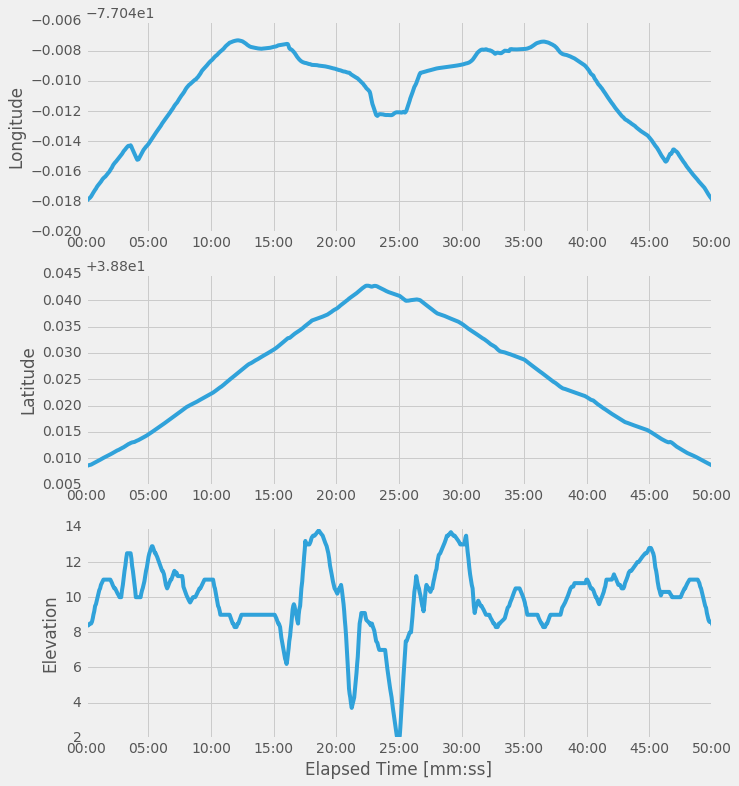

In [165]:
plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.ylabel('Longitude')
plt.plot(times, lng_points)

plt.subplot(3, 1, 2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.ylabel('Latitude')
plt.plot(times, lat_points)

plt.subplot(3, 1, 3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.ylabel('Elevation')
plt.xlabel('Elapsed Time [mm:ss]')
plt.plot(times, ele_points);

It's not easy to visualize the run when you have to think about the latitude and longitude separately, so let's combine them to see a pseudo-map of the total track. The starting and finishing points are very near to one another (as I ran a loop) in the lower left-hand corner of the image below.

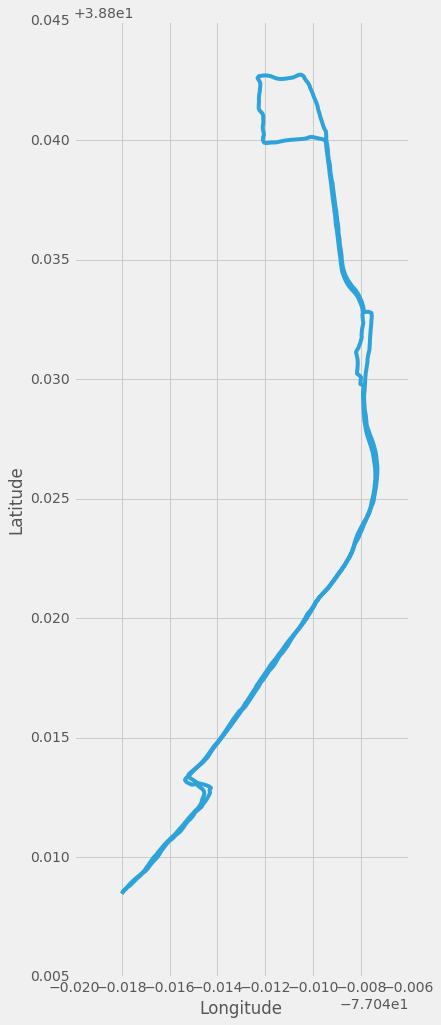

In [85]:
# My run was predominately north-south
plt.figure(figsize=(8,16))
plt.plot(lng_points, lat_points)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axes().set_aspect('equal');

# Converting to cartesian coordinates

The "map" above that shows the run plotted via latitude and longitude is nice, but to start to work toward the speed estimates I want to get, I need to convert into actual distances. That could be a fun exercise in geometry to project the angular lat/long coordinates onto local cartesian coordinates, but it turns out that our planet isn't a proper sphere; it's an oblate spheroid. Unless you want to get really into the weeds of geodesy, it's probably best again to just rely upon someone else's work in the form of a library to transform from lat/long to a cartesian coordinate system. 

I decided to use the [UTM (Universal Transverse Mercator)](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) system to project to local coordinates. The UTM system divides the earth up into a number of (partially overlapping) zones where a locally flat cartesian system isn't *too* bad of an approximation. Within each zone, you describe a position by an _easting_ and a _northing_ offset from the zone's origin. For our purposes, this is our _x_ and _y_ values that we want.



In [25]:
!pip2 install utm

  Using cached utm-0.4.0.tar.gz
  Running setup.py bdist_wheel for utm ... - done
  Stored in directory: /home/jovyan/.cache/pip/wheels/3f/63/d5/f13559eb9b774d66832a0ff8484db33eb8d994e78d7eaf51f9
Successfully built utm


In [125]:
import utm

# The utm library can convert a lat/long pair into an easting, northing, and zone values.
# I don't care about the zone values (the last two elements of the tuple) for the work here.
utm.from_latlon(lat_points[0], lng_points[0])

(321306.23192825, 4297534.641239927, 18, 'S')

It's worth noting that the _easting_ and _northing_ values are in meters. I live in the U.S., where we typically measure long distances in miles, so I'm going to want to convert to miles. I also don't care particularly about the exact values of the locations; I really only want the relative distance from where I started the run.

In [67]:
# The starting point of my run will be the origin of my coordinate system
origin = utm.from_latlon(lat_points[0], lng_points[0])[0:2]

coords = np.array([utm.from_latlon(p[0], p[1])[0:2] for p in zip(lat_points, lng_points)])

# I use a numpy array above so I can easily subtract off the origin value as follows:
coords -= origin

# And finally, let's convert from meters to miles (1 mile ~ 1609.34 meters)
coords /= 1609.34

# Here's what our coordinate positions look like now:
print coords[:10]

[[ 0.          0.        ]
 [ 0.00107179  0.00204576]
 [ 0.00466333  0.00810559]
 [ 0.00942795  0.01351804]
 [ 0.01349421  0.0190842 ]
 [ 0.0188737   0.02303387]
 [ 0.02386654  0.02899316]
 [ 0.02903833  0.03570739]
 [ 0.03336658  0.04092269]
 [ 0.0384149   0.04694974]]


And just to see that the math worked out right, let's look at our _x_-_y_ plot of the positions again, this time in linear units measured in miles.

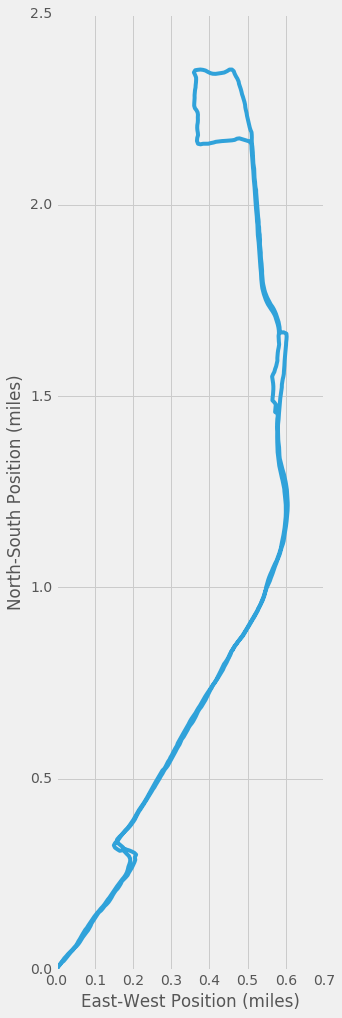

In [86]:
plt.figure(figsize=(8,16))
plt.plot(coords[:,0], coords[:,1])
plt.xlabel('East-West Position (miles)')
plt.ylabel('North-South Position (miles)')
plt.axes().set_aspect('equal');

# Distance and Speed

So, we have a collection of _x_, _y_ coordinates in our desired units (miles) and a collection of times. I now want to compute the distance I traveled, and use that as a means to compute the speed that I was traveling. 

In [76]:
cumulative_distance = 0.0
distances = [0.0]
for i in range(1, len(coords)) :
    p = coords[i]
    q = coords[i-1]
    dist = ((p[0]-q[0])**2 + (p[1]-q[1])**2)**0.5 
    cumulative_distance += dist
    distances.append(cumulative_distance)

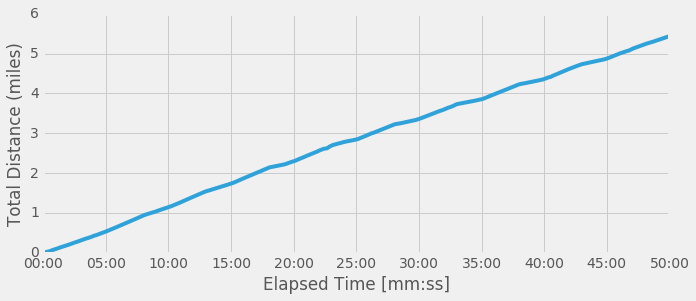

In [166]:
plt.figure(figsize=(10, 4))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.ylabel('Total Distance (miles)')
plt.xlabel('Elapsed Time [mm:ss]')
plt.plot(times, distances);

Now we're getting somewhere.

Let's take a digression for a second and talk about average speed. The average speed over any time interval is just the total distance covered during that interval divided by the duration of that time interval.

In [128]:
from IPython.display import Math
Math(r'v = \frac{d}{\Delta t}')

<IPython.core.display.Math object>

In [147]:
# total distance is just the last element of the `distances` array
d = distances[-1]
print 'Total distance run:', d, 'miles'

# the total time is the difference between the last time and the first time.
# Here I use the total_seconds() method on the timedelta object
delta_t = (times[-1] - times[0]).total_seconds()
minutes, seconds = divmod(delta_t, 60)
print 'Total time: {0:02d}:{1:02d} min'.format(int(minutes), int(seconds))

# Converting from miles per second to miles per hour
v = d / delta_t * 3600
print 'Average speed over entire track:', v, 'mph'

Total distance run: 5.44776203618 miles
Total time: 50:05 min
Average speed over entire track: 6.52643704833 mph


In running, we typically talk about our performance using pace instead of speed. Pace is the inverse of speed. Whereas speed tells you how far you can go in a unit of time, pace tells you how long it takes you to go a unit of distance. The convention is to measure how many minutes it takes per mile.

In [148]:
# Converting from mile per hour to minutes per mile:
pace = 60 / v
print 'Average pace over entire track:', pace, 'min/mile'

Average pace over entire track: 9.19337757427 min/mile


Incidentally, RunKeeper reported that my total distance for this race was 5.45 mi, the total time was 50:05, and the average pace for the entire track was 9.11 min/mile. So, within rounding, the GPX track data agrees on the distance on the time, but we end up with a different average pace. Hmm.

That aside, we can compute an estimate for the average speed between each recorded GPS point by computing the distance between two consecutive points and dividing that by the time elapsed between the two recorded points. 

In [153]:
estimated_speed = []
estimated_pace = []
# We calculate the midpoint of each time interval to be the time at which our speed/pace estimates occur
intermediate_times = []
for i in range(1, len(distances)) :
    d = distances[i] - distances[i-1]
    delta_t = (times[i] - times[i-1]).total_seconds()
    v = d / delta_t * 3600
    pace = 60 / v
    estimated_speed.append(v)
    estimated_pace.append(pace)
    intermediate_times.append( times[i-1] + (times[i]-times[i-1])/2 )

In [343]:
def pace_as_string(pace) :
    return "{0:02d}:{1:02d}".format(int(pace), int( (pace - int(pace))*60 )) 

def average_pace(pace_series) :
    return sum(pace_series)/len(pace_series)

print "Average pace:", pace_as_string(average_pace(estimated_pace))

Average pace: 09:15


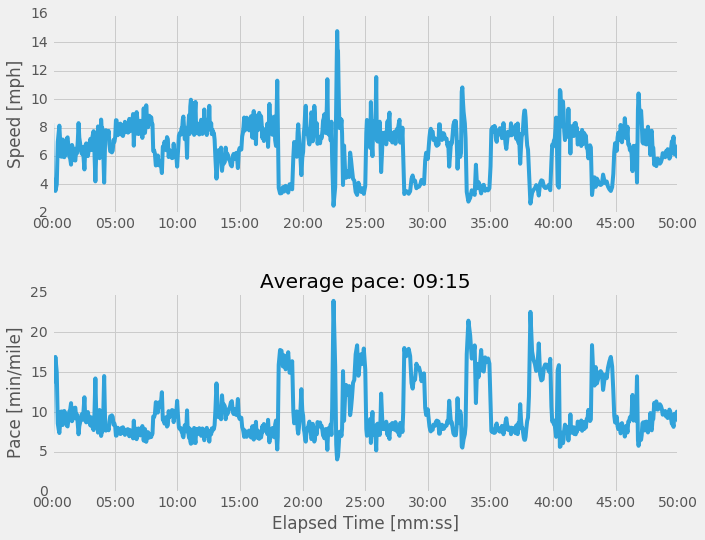

In [358]:
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace = 0.4)

plt.subplot(2, 1, 1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.ylabel('Speed [mph]')
plt.plot(intermediate_times, estimated_speed)

plt.subplot(2, 1, 2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.gca().set_xlim([datetime(1900, 1, 1, 0, 0), datetime(1900, 1, 1, 0, 50)])
plt.title( 'Average pace: '+ pace_as_string(average_pace(estimated_pace)) )
plt.ylabel('Pace [min/mile]')
plt.xlabel('Elapsed Time [mm:ss]')
plt.plot(intermediate_times, estimated_pace);

Now, I can understand why the developers at RunKeeper wouldn't want to show a graph like this to users. It's incredibly noisy and very difficult to interpret. You can roughly see where the boundaries of each interval were because there's a big jump up or down. It's also instructive to look at speed and pace stacked like this, as they're inverses of each other. On the graphs, that makes them look somewhat (but not entirely) like mirror images (reflected vertically) of each other. As one should expect, when speed is high, pace is low, and vice-versa.

As noisy as these graphs are, I suspect that some of the high/low values and the overall trend are more likely to be accurate measures of my pace than the chart that the RunKeeper iOS app provides (at the very top of this notebook).

One thing I need to tweak, though, to offer a fair apples-to-apples comparison with the app's chart is to change the independent variable. Above, I'm plotting the speed/pace versus time. The RunKeeper app plots the pace versus distance. That's an easy tweak, but the main effect will simply be to squeeze the rest periods (because I was moving at a slower speed, I covered less distance during each 2-minute recovery interval). Otherwise the graph will still look fairly similar.

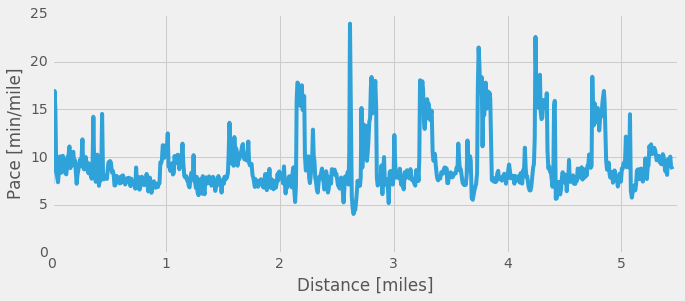

In [170]:
plt.figure(figsize=(10, 4))
plt.ylabel('Pace [min/mile]')
plt.xlabel('Distance [miles]')
plt.gca().set_xlim([0, 5.5])
plt.plot(distances[1:], estimated_pace);

Where should I go from here to see if it's possible to produce something that's substantially less noisy (more like the RunKeeper plot) but still preserves the range limits of my pace that I think are likely to be accurate? I've got a couple of ideas.

* I could apply a sliding window average on the data. A large enough window would definitely help damp out some of the high frequency oscillations, but this will also skew the peaks by dragging the extremes toward the middle.

* I could try taking the pace data and run it through a _low-pass_ smoothing filter. A low-pass filter allows low-frequency (slowly changing) data through, but filters high frequency (rapidly changing) signals out.

* I used a very simple calculation for average speed for an interval that only used the distance traveled during that interval. There are more sophisticated methods that I could use that factor in neighboring values in time. For example, there's a derivation of the [five-point stencil](https://en.wikipedia.org/wiki/Five-point_stencil) from numerical analysis (this is really bringing me back to my grad school days!). The catch here is that most formulas for providing higher-order derivative calculations presume constant interval spacing. The elapsed time between each observation is not constant, so a lot of the easy formulas don't apply to this case.

* That leads to possibly looking at smooth spline approximations.

* If I want to break out the _really_ big guns, I could go back to the 2D position data and see if I could apply a [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter) to it and use it to estimate the likely "true" positions and speeds from the data. I'm going to be honest, I really don't want to have to try this, but I came across [this presentation](https://realm.io/news/mbltdev-phillip-connaughton-runkeeper/) from RunKeeper developer [Phillip Connaughton](https://twitter.com/pconno3) that says that they do use a Kalman filter to smooth the GPS data. It's unclear to me whether what I export from RunKeeper has already been smoothed (I suspect so) or if it's the raw (but culled) data that the device's GPS chip provided.

I ordered this list roughly by ease of experimentation so I can try the simpler approaches first and see if I make any headway there before getting into the harder-hitting stuff.

# Approaches for Processing the Pace Data

## Sliding window averages

So let's start with the cheapest operation: computing a sliding window average. I could roll my own implementation, but I'm going to use this as an opportunity to learn a little bit more about the [pandas](http://pandas.pydata.org/) library that I've been meaning to try out. Our distance, speed, and pace data are all time-series data (a singular value measured at different timestamps), so let's create a Pandas `Series` for the pace data.

In [179]:
import pandas as pd

# time_index = pd.to_datetime(intermediate_times)
ts = pd.Series(estimated_pace, index=distances[1:])

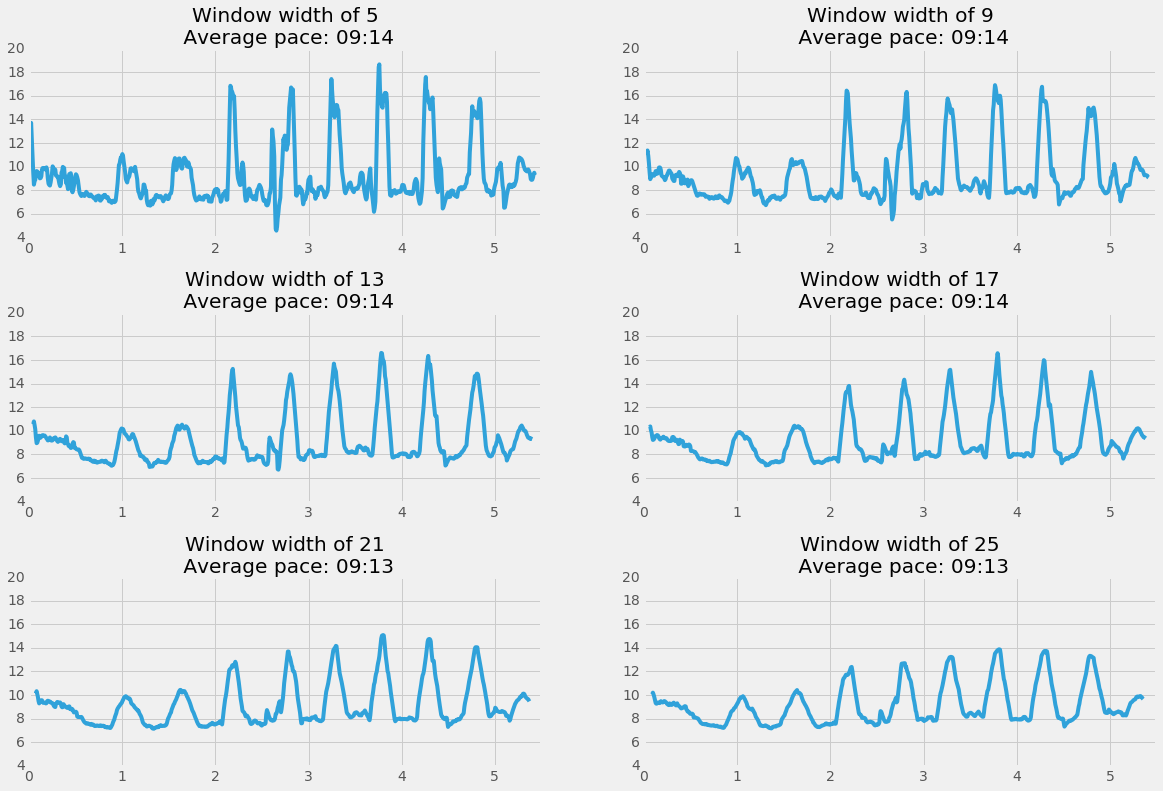

In [357]:
plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace = 0.4)

for i in range(0, 6) :
    w = 5 + i*4
    averaged = pd.rolling_mean(ts, window=w, center=True)
    plt.subplot(3, 2, i+1)
    plt.gca().set_xlim([0, 5.5])
    plt.gca().set_ylim([4,20])
    paces = [y for y in averaged][w/2:-w/2]
    plt.title('Window width of {0}\n Average pace: {1}'.format(w, pace_as_string(average_pace(paces))))
    plt.plot(distances[w/2+1:-w/2], paces)

The sliding window average clearly does help smooth the data, but it also has the effect of pulling the extreme values (both high and low) toward the center. The widths of the high-pace peaks (which again represent recovery periods where I was either jogging considerably slower or walking) get wider as the the peaks themselves shorter when the window width increases. Also, with larger window widths, it's necessary to lose more and more of the data from the beginning and end of the run. That's affecting the overall pace. Clearly none of these match what RunKeeper plots, so they're likely using a different technique. 

## Low-pass smoothing filter

For this, I cracked open my copy of _Numercial Recipes: The Art of Scientific Computing (3rd Ed.)_, which I probably haven't looked at in seven or more years. Section 14.9 presents the _Savitzky-Golay Smoothing Filter_, which they claim is often useful in cleaning up noisy spectroscopic data.

I'm going to give that a shot and see if that helps. This algorithm provides a potentially interesting second option that I hadn't considered before. Rather than applying a filter to the velocity data itself, I could look to smooth the distance data and compute the first-order derivative (the speed).

Strictly speaking, I can't use the out-of-the-box algorithm because the data isn't uniformly spaced in time. The authors of _Numerical Recipes_ have a comment about this (p. 771):
> A last remark concerns irregulary sampled data, where the values f_i are not uniformly spaced in time. The obvious generalization of Savitsky-Golay filtering would be to do a least-squares fit within a moving window around each data point, one containing a fixed number of data points to the left (_n<sub>L</sub>_) and right (_n<sub>R</sub>_). Because of the irregular spacing, however, there is no way to obtain universal filter coefficients applicable to more than one data point. One must instead do the actual least-squares fits for each data point. This becomes computationally burdensome for larger _n<sub>L</sub>_, _n<sub>R</sub>_, and _M_.

> As a cheap alternative, one can simply pretend that the data points _are_ equally spaced. This amounts to virtually shifting, within each moving window, the data points to equally spaced positions. Such a shift introduces the equivalent of an additional source of noise into the function values. In those cases where smoothing is useful, this noise will often be much smaller than the noise already present. Specifically, if the location of the points is approximately random within the window, then a rough criterion is this: If the change in _f_ across the full width of the _N_ = _n<sub>L</sub>_ + _n<sub>R</sub>_ + 1 point window is less than sqrt(_N_/2) times the measurement noise on a single point, then the cheap method can be used.

Again, following the philosophy of trying the easiest possible thing first, let's start with some experiments in seeing how this smoothing filter works.

The fine folks that contributed to the [SciPy Cookbook](http://scipy-cookbook.readthedocs.io/index.html) have an implementation that I'm going to paste here (available at http://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html):


In [237]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

Let's see how this looks over a range of different window widths, keeping the order (of the polynomial fit at each point) fixed initially. I'll start with just a second-order polynomial.

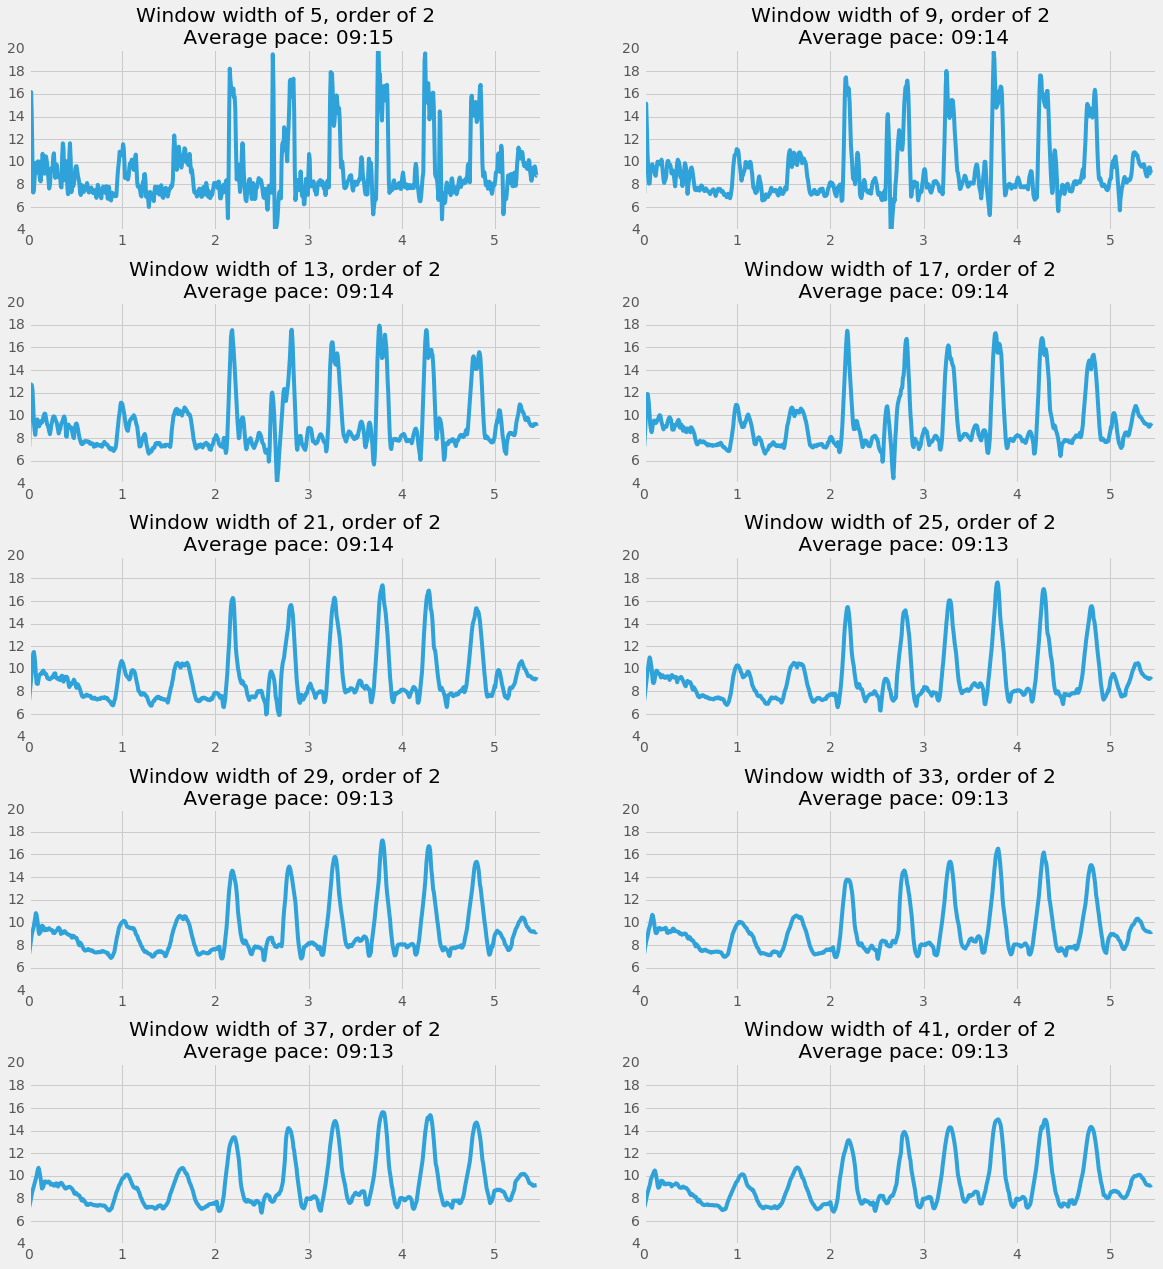

In [356]:
plt.figure(figsize=(18, 20))
plt.subplots_adjust(hspace = 0.4)

for i in range(0, 10) :
    poly_order = 2
    w = 5 + i*4
    smoothed = savitzky_golay(estimated_pace, window_size=w, order = poly_order, deriv = 0)
    plt.subplot(5, 2, i+1)
    plt.gca().set_xlim([0, 5.5])
    plt.gca().set_ylim([4,20])
    plt.title('Window width of {0}, order of {1}\n Average pace: {2}'.format(w, 
                                            poly_order, pace_as_string(average_pace(smoothed))))
    plt.plot(distances[1:], smoothed)

It's already possible to tell with this that, while we are seeing some changes in the extreme values (bringing the peaks down), it's nowhere near as extreme as we saw with the sliding window average method. As before, though, as we increase the window width, we're starting to see more skew from effects happening at the very beginning and end of our series. Let's see what happens now if we keep the window size fixed, and we vary the order (of the fit polynomials). Increasing the order will allow more high frequency oscillations back into the mix, so we can expect that it will start to get noisier again. I felt like a window width of 25 points was a decent compromise between smoothing and still preserving features, so that's what I've tested below.

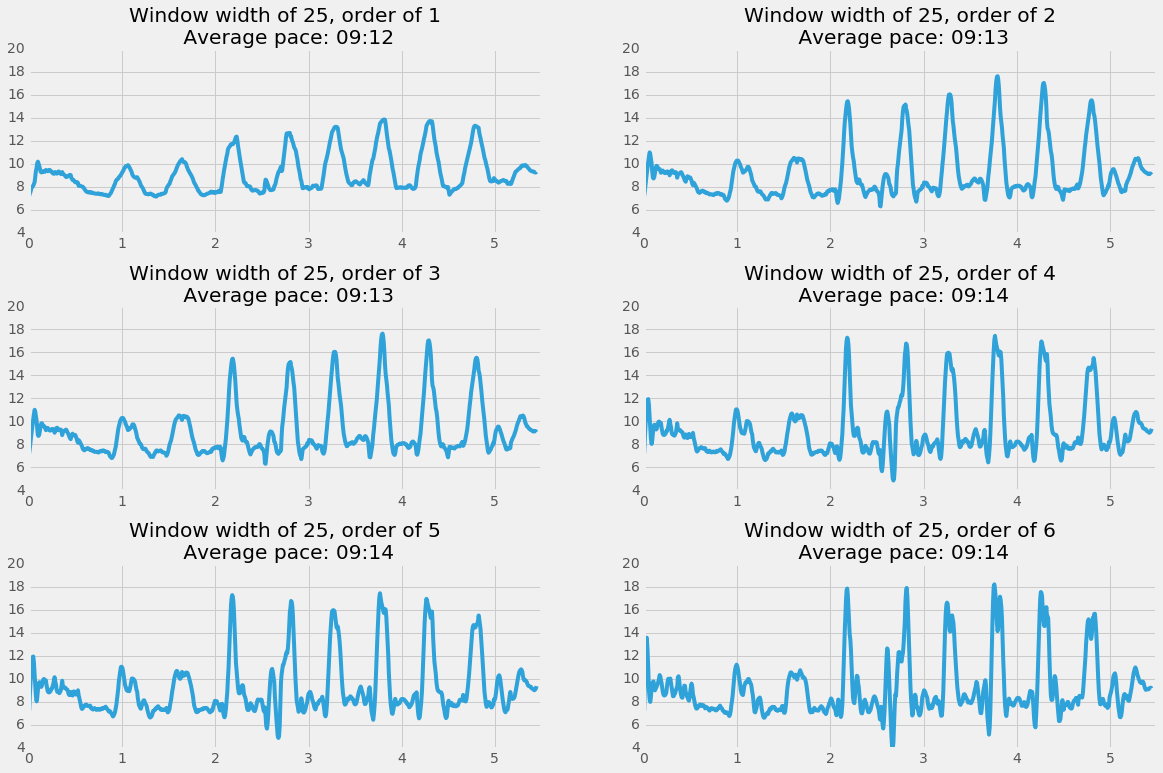

In [355]:
plt.figure(figsize=(18, 16))
plt.subplots_adjust(hspace = 0.4)

for i in range(1, 7) :
    poly_order = i
    w = 25
    smoothed = savitzky_golay(estimated_pace, window_size=w, order = poly_order, deriv = 0)
    plt.subplot(4, 2, i)
    plt.gca().set_xlim([0, 5.5])
    plt.gca().set_ylim([4,20])
    plt.title('Window width of {0}, order of {1}\n Average pace: {2}'.format(w, 
                                            poly_order, pace_as_string(average_pace(smoothed))))
    plt.plot(distances[1:], smoothed)

At this point, it may be getting into individual tastes, but I think the window width of 25 and order of 2 is actually pretty good. This still doesn't match the graph that RunKeeper produces by a long shot, so clearly they're doing something else, but I feel like this is a good place to draw it back to my original concern that launched me into all this madness: do any of these graphs better reflect the interval average paces that were recorded for each of the intervals I ran?

## Interval pace comparison

In [421]:
def parce_pace(pace_string) :
    m,s = pace_string.split(':')
    return int(m) + int(s)/60.0

# This is a list of the average interval paces reported by RunKeeper
interval_paces = map(parce_pace, ['9:25', 
                                  '7:24', 
                                  '9:44', 
                                  '7:30', 
                                  '10:16', 
                                  '7:32', 
                                  '12:16', 
                                  '7:43', 
                                  '12:51', 
                                  '7:58', 
                                  '14:02', 
                                  '8:12', 
                                  '15:44', 
                                  '8:00', 
                                  '14:37', 
                                  '8:09', 
                                  '13:39', 
                                  '8:25', 
                                  '9:46',
                                  '9:08'])

In [493]:
# I want to find the index of the datapoint when an interval ends
from datetime import timedelta
# After the first five-minute warm-up, there were nine intervals of 3-min fast and 2-min recovery
# plus one extra bit at the end for me to stop the tracking
intervals = [5, 3,2, 3,2, 3,2, 3,2, 3,2, 3,2, 3,2, 3,2, 3,2, 1]

next_limit = times[0] + timedelta(0, intervals[0]*60 )
j = 1
interval_bounds = []
for i in range(len(times)) :
    if times[i] > next_limit :
        j += 1
        next_limit = times[0] + timedelta(0, sum(intervals[0:j])*60)
        interval_bounds.append(i)
interval_bounds.append(len(times))

In [494]:
interval_pace_data = [interval_paces[-1]]*len(times)
j = 0
for i, limit in enumerate(interval_bounds) :
    while j < limit and i < len(interval_paces):
        interval_pace_data[j] = interval_paces[i]
        j += 1

Now I'm ready to compare the average interval paces that RunKeeper reported against my smoothed speed data to see how they compare.

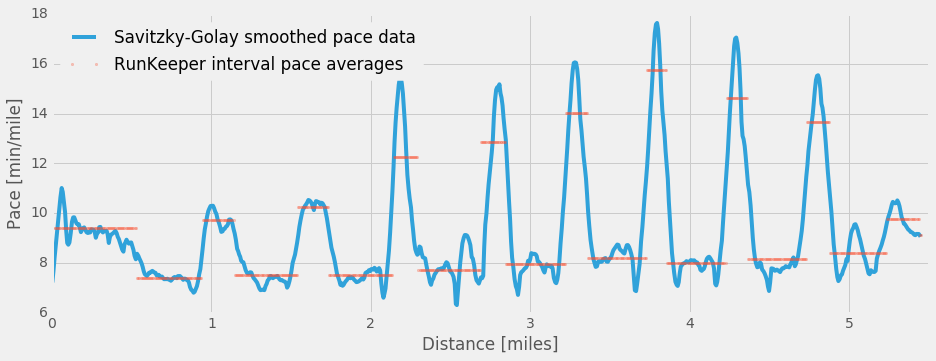

In [495]:
smoothed = savitzky_golay(estimated_pace, window_size=25, order = 2, deriv = 0)

plt.figure(figsize=(14, 5))
plt.ylabel('Pace [min/mile]')
plt.xlabel('Distance [miles]')
plt.gca().set_xlim([0, 5.5])
plt.plot( distances[1:], smoothed, label="Savitzky-Golay smoothed pace data")
plt.plot( distances, interval_pace_data, '.', marker = '.', markersize=5, alpha=0.3, label="RunKeeper interval pace averages")
plt.legend(loc=0);

I actually think that looks pretty good! It's still a bit noisy, and perhaps there are better parameters that could smooth it out without losing too much detail, but it's possible here to see that during each interval, the smoothed data remains close to the average pace or it's more obvious that the data has values way above and way below the average.

If you look back at the pace chart from the app, I think it's clear that whatever process in place to compute the instantaneous pace data is misleading:

![Pace chart from RunKeeper iOS app](RunKeeper-iOS-PaceChart.png)

# Conclusions

I'd like to wrap this up exercise as I began: I really do like the RunKeeper app, and I think it provides a great service for just about anyone looking to be active and track their progress. The data I was seeing in the app did not seem consistent to me, so I wanted to do a little digging into where the discrepancy might be.

Perhaps the folks at RunKeeper might take this approach and update the app, or perhaps there's a bug in their current implementation that this might bring to light. Either way, this was a fun opportunity for me to try to learn a bit more about some of the newer scientific computing capabilities that have matured in the Python ecosystem since the last time I had a look.